pip install torchcp

In [49]:
pip install --index-url https://test.pypi.org/simple/ --no-deps torchcp

Looking in indexes: https://test.pypi.org/simple/, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [1]:
from torchcp.classification.scores import THR, APS, SAPS, RAPS
from torchcp.classification.predictors import SplitPredictor, ClusterPredictor, ClassWisePredictor
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision import datasets
from torchvision import transforms
import torchvision

In [2]:
batch_size = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
#These are for 2.2, 2.3

# transform_test = transforms.Compose([
#     transforms.Resize(size=224),
#     transforms.CenterCrop(size=(224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

# #data = torchvision.datasets.DTD(root='/shareddata', split='test', download=True, transform=transform_test)

# #data = torchvision.datasets.OxfordIIITPet(root='/shareddata', split='test',download=True, transform=transform_test)

# #data = torchvision.datasets.CIFAR100(root='/shareddata', train=False,download=True, transform=transform_test)

# #data= torchvision.datasets.Food101(root='/shareddata', split='test',download=True, transform=transform_test)

# train_data=torchvision.datasets.CIFAR10(root='/shareddata', train=True,download=True, transform=transform_test)
# test_data=torchvision.datasets.CIFAR10(root='/shareddata', train=False,download=True, transform=transform_test)
# train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# num_train = int(len(test_data) * 0.5)
# num_test = len(test_data) - num_train

# cal_dataset, test_dataset = torch.utils.data.random_split(test_data, [num_train, num_test])


# cal_dataloader= torch.utils.data.DataLoader(cal_dataset, batch_size=batch_size,
#                                          shuffle=False, num_workers=1)

# model=torchvision.models.alexnet(pretrained=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(32 * 8 * 8, 256)
        self.fc2 = torch.nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
#CIFAR-10
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./shareddata', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./shareddata', train=False, download=True, transform=transform)

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# train_dataset = torchvision.datasets.CIFAR100(root='./shareddata', train=True, download=True, transform=transform)
# test_dataset = torchvision.datasets.CIFAR100(root='./shareddata', train=False, download=True, transform=transform)

# batch_size =32

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# train_dataset = torchvision.datasets.Food101(root='./shareddata', split='train', download=True, transform=transform)
# test_dataset = torchvision.datasets.Food101(root='/shareddata', split='test',download=True, transform=transform)

# batch_size =32

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
model = SimpleCNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [6]:
model.eval()
score_functions = [THR(score_type='softmax'), APS(), SAPS(weight=0.3), RAPS(penalty=0.5)]
predictors = [SplitPredictor, ClusterPredictor, ClassWisePredictor]  
score_functions_names = ['THR', 'APS', 'SAPS', 'RAPS']
predictors_names = ['SplitPredictor', 'ClusterPredictor', 'ClassWisePredictor']  
cal_dataloader=DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
converge_list = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
size_list=[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
for i in range(3):
    for j in range(4):
        predictor = predictors[i](score_function=score_functions[j], model=model)

        # Calibrating the predictor with significance level as 0.1
        predictor.calibrate(cal_dataloader, alpha=0.1)
        result_dict = predictor.evaluate(test_dataloader)
        converge_list[i][j]=result_dict["Coverage_rate"]
        size_list[i][j]=result_dict["Average_size"]
        print(result_dict)
converge_array = np.array(converge_list)
size_array=np.array(size_list)

{'Coverage_rate': 0.9, 'Average_size': 2.0892}
{'Coverage_rate': 0.8991, 'Average_size': 2.2143}
{'Coverage_rate': 0.899, 'Average_size': 2.3209}
{'Coverage_rate': 0.8992, 'Average_size': 2.3097}
{'Coverage_rate': 0.8992, 'Average_size': 2.0812}
{'Coverage_rate': 0.9002, 'Average_size': 2.2456}
{'Coverage_rate': 0.9006, 'Average_size': 2.3547}
{'Coverage_rate': 0.902, 'Average_size': 2.333}
{'Coverage_rate': 0.9, 'Average_size': 2.1063}
{'Coverage_rate': 0.9018, 'Average_size': 2.2797}
{'Coverage_rate': 0.8999, 'Average_size': 2.3497}
{'Coverage_rate': 0.9024, 'Average_size': 2.339}


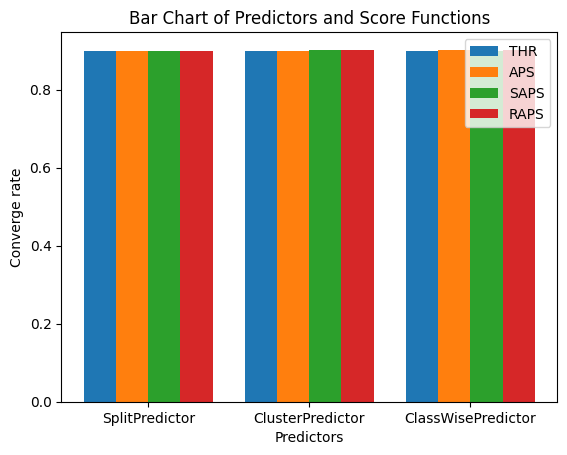

In [8]:
import matplotlib.pyplot as plt
import numpy as np


score_functions_names = ['THR', 'APS', 'SAPS', 'RAPS']
predictors_names = ['SplitPredictor', 'ClusterPredictor', 'ClassWisePredictor']


# 绘制柱状图
bar_width = 0.2
index = np.arange(len(predictors_names))

fig, ax = plt.subplots()

for i, score_function in enumerate(score_functions_names):
    ax.bar(index + i * bar_width, converge_array[:, i], bar_width, label=score_function)

ax.set_xlabel('Predictors')
ax.set_ylabel('Converge rate')
ax.set_title('Bar Chart of Predictors and Score Functions')
ax.set_xticks(index + bar_width * (len(score_functions_names) - 1) / 2)
ax.set_xticklabels(predictors_names)
ax.legend()
plt.show()

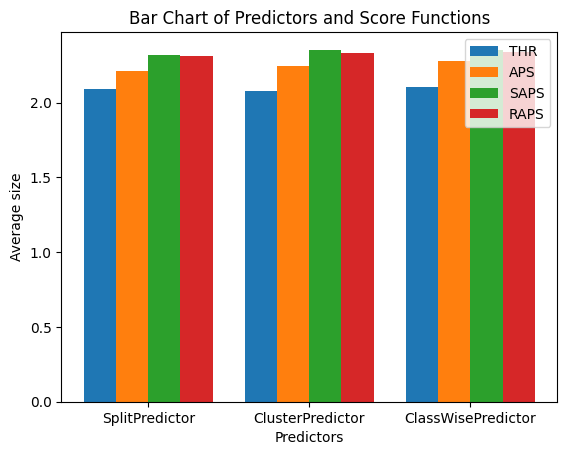

In [9]:
#plot2
score_functions_names = ['THR', 'APS', 'SAPS', 'RAPS']
predictors_names = ['SplitPredictor', 'ClusterPredictor', 'ClassWisePredictor']


# 绘制柱状图
bar_width = 0.2
index = np.arange(len(predictors_names))

fig, ax = plt.subplots()

for i, score_function in enumerate(score_functions_names):
    ax.bar(index + i * bar_width, size_array[:, i], bar_width, label=score_function)

ax.set_xlabel('Predictors')
ax.set_ylabel('Average size')
ax.set_title('Bar Chart of Predictors and Score Functions')
ax.set_xticks(index + bar_width * (len(score_functions_names) - 1) / 2)
ax.set_xticklabels(predictors_names)
ax.legend()
plt.show()